### Creating The Dataset
###### As no dataset is given, scikit learn is used to generate toy data

In [77]:
# Necessary imports
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [78]:
X_train, y = make_blobs(n_samples=1000, centers=2,
                        n_features=2, random_state=1)


### Creating the SMO class and initializing the needful parameters

In [79]:
class SMOModel:
    """Container object for the model used for sequential minimal optimization."""
    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

### Using Linear Kernel only.

In [80]:
def linear_kernel(x, y, b=1): 
    return x @ y.T + b # Note the @ operator for matrix multiplication

### The function to optimize and taking final decision

In [81]:
def objective_function(alphas, target, kernel, X_train):    
    return np.sum(alphas) - 0.5 * np.sum(target * target * kernel(X_train, X_train) * alphas * alphas)

def decision_function(alphas, target, kernel, X_train, x_test, b):   
    return ((alphas * target) @ kernel(X_train, x_test) - b)

### Heart of the Program
-  Compute the bounds of alphas
-  Compute Second Derivative for optimization
-  Check if the chosen alphas can be optmized 
-  Implementation according to the paper

In [82]:
def take_step(i1, i2, model):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

def examine_example(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
            
        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    return 0, model

### Function to train the model using SMO defined earlier

In [83]:
def train(model):
    
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return model

### Helper Function to scale the data to center and have a unit standard deviation.

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)

### Changing the outputs to -1 and 1 instead of 0 and 1

In [85]:
y[y == 0] = -1

### Initializing all the parameters

In [86]:
# Set model parameters and initial values
C = 1000.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

### This is where the actual training happens

##### Seed is used for reproducibility

In [87]:
np.random.seed(0)
output = train(model)

### Function for plotting the decision boundary generated after training the model

In [88]:
def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r')):
    
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for yr in yrange] for xr in xrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        ax.contour(xrange, yrange, grid, (-1, 0, 1), linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                  c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.5)
        
        mask = model.alphas != 0.0
        ax.scatter(model.X[:,0][mask], model.X[:,1][mask],
                 c=model.y[mask], cmap=plt.cm.viridis)       
        
        plt.show()
        return grid, ax

### This is how our hard-margin SVM model looks for the toy dataset

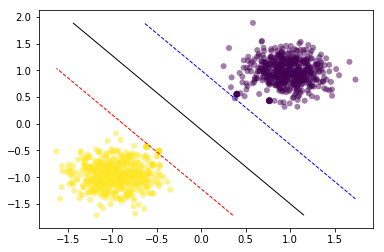

In [89]:
fig, ax = plt.subplots()
grid,ax =plot_decision_boundary(output, ax)


### These are the support vectors which have non-zero alphas

In [91]:
output.alphas[output.alphas != 0]

array([  1.09686137e+00,   1.38777878e-17,   2.77555756e-17,
         2.22050604e-02,   1.07465631e+00])

### Can this hard-margin SVM handle outliers?

In [92]:
X_outlier = np.append(X_train_scaled, [0.1, 0.1])
X_outlier = X_outlier.reshape(X_train.shape[0]+1, X_train.shape[1])
y_outlier = np.append(y, 1)

In [93]:
# Set model parameters and initial values
C = 1000.0
m = len(X_outlier)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

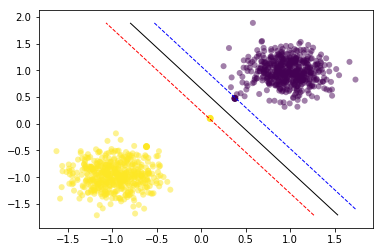

In [94]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)


### As you can see, the answer is NO!
***
### Using soft-margin SVM to handle Outliers

In [95]:
# Set model parameters and initial values
C = 1.0

initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_outlier, y_outlier, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

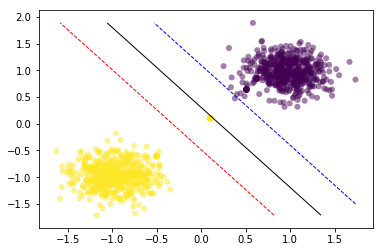

In [96]:
output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)